# Network Analysis of COVID-19 Data

This project analyzes a network constructed from a COVID-19 dataset to study its structural properties, resilience, community structure, and opinion dynamics. The dataset contains country-wise COVID-19 statistics, and the network is built by connecting countries with similar confirmed case counts.

## Dataset Description
- **Source**: Kaggle (https://www.kaggle.com/datasets/sudalairajkumar/novel-corona-virus-2019-dataset)
- **Format**: CSV
- **Size**: 187 rows (countries), 15 columns (e.g., Confirmed, Deaths, Recovered, WHO Region)
- **Network Type**: Undirected, weighted
- **Initial Observations**: The dataset is complete with no missing or duplicate entries. The network is constructed based on a threshold difference in confirmed cases.

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community.quality import modularity
import random
import os
from networkx.algorithms.community import girvan_newman, modularity
import time
import community as community_louvain  # مكتبة python-louvain لخوارزمية Louvain
from itertools import islice


## Data Loading and Exploration
Load the dataset and perform initial exploration to understand its structure and ensure data quality.

In [3]:
# Define the full file path
file_path = r'C:\Users\mla\OneDrive\Desktop\Social\country_wise_latest.csv'

# Check if the file exists
if os.path.exists(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Display basic information
    print("First 5 rows:")
    print(df.head())
    
    print("\nDataFrame Info:")
    print(df.info())
    
    print("\nStatistical Description:")
    print(df.describe())
    
    print("\nMissing Values per Column:")
    print(df.isnull().sum())
    
    print("\nNumber of Duplicate Rows:")
    print(df.duplicated().sum())
else:
    print(f"Error: The file '{file_path}' was not found. Please ensure it exists at the specified path.")

First 5 rows:
  Country/Region  Confirmed  Deaths  Recovered  Active  New cases  New deaths  \
0    Afghanistan      36263    1269      25198    9796        106          10   
1        Albania       4880     144       2745    1991        117           6   
2        Algeria      27973    1163      18837    7973        616           8   
3        Andorra        907      52        803      52         10           0   
4         Angola        950      41        242     667         18           1   

   New recovered  Deaths / 100 Cases  Recovered / 100 Cases  \
0             18                3.50                  69.49   
1             63                2.95                  56.25   
2            749                4.16                  67.34   
3              0                5.73                  88.53   
4              0                4.32                  25.47   

   Deaths / 100 Recovered  Confirmed last week  1 week change  \
0                    5.04                35526         

c:\Users\mla\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


## Network Construction
Construct a network where nodes represent countries, and edges connect countries with similar confirmed case counts (difference ≤ 10,000).

In [4]:
# Initialize the graph
threshold = 10000
G = nx.Graph()

# Add nodes with 'Confirmed' as an attribute
for _, row in df.iterrows():
    G.add_node(row['Country/Region'], confirmed=row['Confirmed'])

# Add weighted edges based on the threshold
for country1, country2 in itertools.combinations(df['Country/Region'], 2):
    val1 = df[df['Country/Region'] == country1]['Confirmed'].values[0]
    val2 = df[df['Country/Region'] == country2]['Confirmed'].values[0]
    if abs(val1 - val2) <= threshold:
        G.add_edge(country1, country2, weight=1 / (abs(val1 - val2) + 1))  # Weighted edge

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

# Network statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_degree = sum(dict(G.degree()).values()) / num_nodes if num_nodes > 0 else 0
density = nx.density(G)

print("\nNetwork Statistics:")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average Degree: {average_degree:.2f}")
print(f"Density: {density:.3f}")
print(f"Isolated Nodes Removed: {isolated_nodes}")


Network Statistics:
Number of nodes: 177
Number of edges: 6588
Average Degree: 74.44
Density: 0.423
Isolated Nodes Removed: ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Germany', 'India', 'Italy', 'Russia', 'South Africa', 'US']


## Exploratory Network Analysis
Analyze the network's structure, including degree distribution, centrality measures, and connectivity.

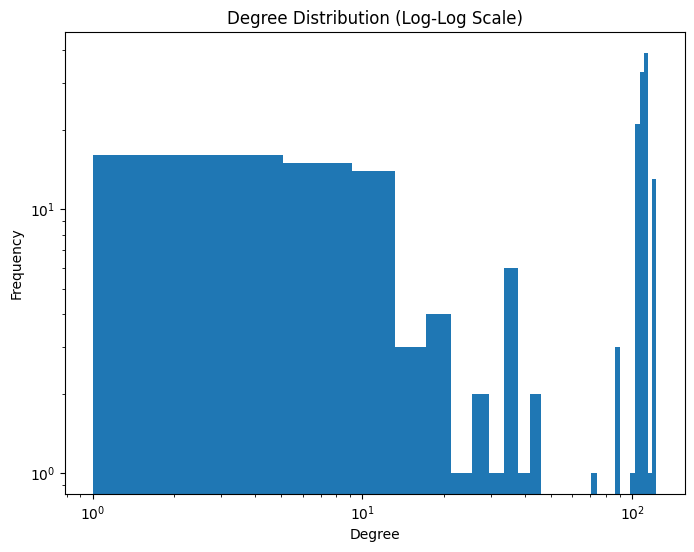


Top 5 Nodes by Degree Centrality:
[('Congo (Kinshasa)', 0.6988636363636364), ('Madagascar', 0.6988636363636364), ('Malaysia', 0.6988636363636364), ('Norway', 0.6988636363636364), ('Senegal', 0.6988636363636364)]

Top 5 Nodes by Betweenness Centrality:
[('United Arab Emirates', 0.13522925580500653), ('Serbia', 0.1082196096022918), ('Algeria', 0.09619839060005804), ('Nigeria', 0.08764543052174775), ('Ghana', 0.08130425907796048)]

Connectivity Analysis:
Is the network connected? False
Size of the largest connected component: 167


In [5]:
# Degree distribution (log-log scale)
degrees = [degree for _, degree in G.degree()]
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=30, log=True)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('degree_distribution.png')
plt.show()

# Centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

print("\nTop 5 Nodes by Degree Centrality:")
print(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop 5 Nodes by Betweenness Centrality:")
print(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

# Connectivity
is_connected = nx.is_connected(G)
largest_cc = len(max(nx.connected_components(G), key=len))
print("\nConnectivity Analysis:")
print(f"Is the network connected? {is_connected}")
print(f"Size of the largest connected component: {largest_cc}")

## Network Robustness Testing
Test the network's resilience against random failures and targeted attacks by removing nodes and measuring the size of the largest connected component.

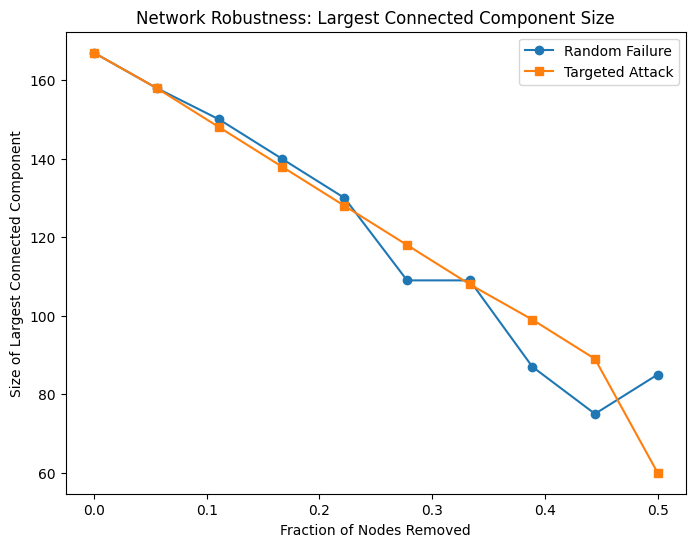

In [6]:
def simulate_random_failure(G, fraction):
    G_copy = G.copy()
    nodes_to_remove = random.sample(list(G_copy.nodes()), int(fraction * G_copy.number_of_nodes()))
    G_copy.remove_nodes_from(nodes_to_remove)
    return len(max(nx.connected_components(G_copy), key=len)) if G_copy.number_of_nodes() > 0 else 0

def simulate_targeted_attack(G, fraction):
    G_copy = G.copy()
    degree_centrality = nx.degree_centrality(G_copy)
    nodes_sorted = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    nodes_to_remove = [node for node, _ in nodes_sorted[:int(fraction * G_copy.number_of_nodes())]]
    G_copy.remove_nodes_from(nodes_to_remove)
    return len(max(nx.connected_components(G_copy), key=len)) if G_copy.number_of_nodes() > 0 else 0

# Simulate failures and attacks
fractions = np.linspace(0, 0.5, 10)
random_sizes = [simulate_random_failure(G, f) for f in fractions]
targeted_sizes = [simulate_targeted_attack(G, f) for f in fractions]

# Plot robustness curves
plt.figure(figsize=(8, 6))
plt.plot(fractions, random_sizes, label='Random Failure', marker='o')
plt.plot(fractions, targeted_sizes, label='Targeted Attack', marker='s')
plt.title('Network Robustness: Largest Connected Component Size')
plt.xlabel('Fraction of Nodes Removed')
plt.ylabel('Size of Largest Connected Component')
plt.legend()
plt.savefig('robustness_curves.png')
plt.show()

## Community Detection
Identify communities in the network using the Girvan-Newman algorithm and evaluate their quality with modularity.

Girvan-Newman Algorithm used (first level).
Community Detection Time: 2.51 seconds

Community Detection Results:
Modularity Score: 0.0029
Number of Communities: 6
Using Kamada-Kawai layout for faster visualization.


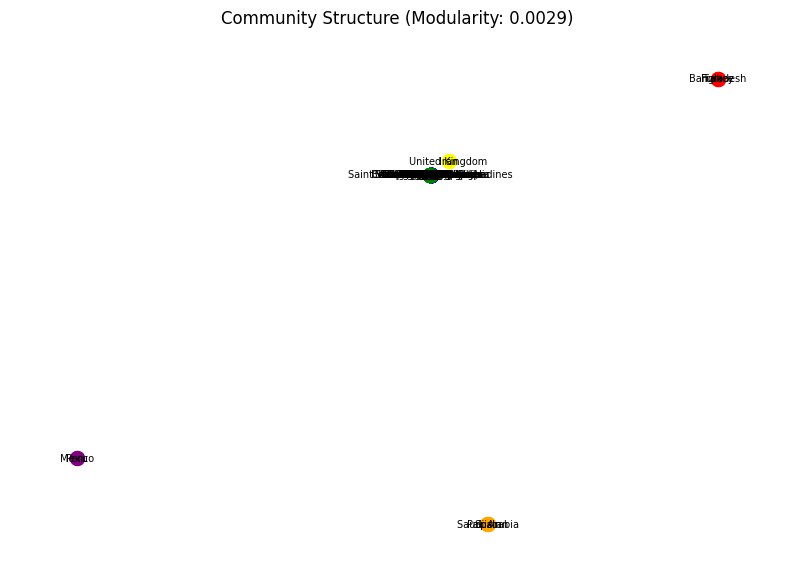

Visualization Time: 4.79 seconds
Total Execution Time: 7.30 seconds


In [ ]:


# Calculate modularity
def detect_communities(G):
    start_time = time.time()
    
    # استخدام Girvan-Newman مع الحد من التكرارات
    communities_gen = girvan_newman(G)
    # أخذ أول تقسيم فقط لتقليل وقت الحساب
    communities = next(islice(communities_gen, 0, 1))
    communities = list(communities)
    mod_score = modularity(G, communities)
    print(f"Girvan-Newman Algorithm used (first level).")

    end_time = time.time()
    print(f"Community Detection Time: {end_time - start_time:.2f} seconds")
    return communities, mod_score

# دالة لتصور المجتمعات
def visualize_communities(G, communities, mod_score):
    start_time = time.time()
    
    # استخدام تخطيط أسرع (kamada_kawai_layout) إذا كانت الشبكة كبيرة
    if G.number_of_nodes() > 100:
        pos = nx.kamada_kawai_layout(G)
        print("Using Kamada-Kawai layout for faster visualization.")
    else:
        pos = nx.spring_layout(G, seed=42)
        print("Using Spring layout.")

    plt.figure(figsize=(10, 7))
    colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta']
    
    # رسم العقد حسب المجتمعات
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=list(community), 
                              node_color=colors[i % len(colors)], 
                              node_size=100)
    
    # رسم الأضلاع
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    # رسم التسميات
    nx.draw_networkx_labels(G, pos, font_size=7)
    
    plt.title(f'Community Structure (Modularity: {mod_score:.4f})')
    plt.axis('off')
    
    # حفظ الصورة
    plt.savefig('community_structure.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    end_time = time.time()
    print(f"Visualization Time: {end_time - start_time:.2f} seconds")

# افتراض أن G هي الشبكة الجاهزة
# مثال: G = nx.karate_club_graph()  # للاختبار
# G = <الشبكة الخاصة بك>

# قياس الوقت الكلي
start_time = time.time()

# تشغيل اكتشاف المجتمعات
communities, mod_score = detect_communities(G)

# طباعة النتائج
print("\nCommunity Detection Results:")
print(f"Modularity Score: {mod_score:.4f}")
print(f"Number of Communities: {len(communities)}")

# تصور المجتمعات
visualize_communities(G, communities, mod_score)

# طباعة الوقت الكلي
total_time = time.time() - start_time
print(f"Total Execution Time: {total_time:.2f} seconds")


## Opinion Dynamics Simulation


Simulation Time: 0.38 seconds


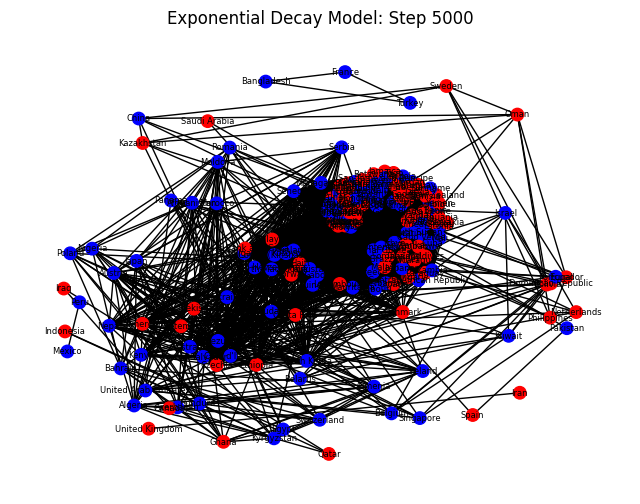

Animation Time: 362.93 seconds

Opinion Dynamics Results:
Time to Consensus: 5000 steps
Number of Frames in Animation: 501
Total Execution Time: 363.31 seconds


In [ ]:
# إزالة العقد المعزولة لتسريع المحاكاة
#Exponential Decay Model
G.remove_nodes_from(list(nx.isolates(G)))

# تهيئة الآراء عشوائيًا (0 أو 1)
for node in G.nodes():
    G.nodes[node]['opinion'] = random.choice([0, 1])

# معدل التلاشي الأسي
decay_rate = 0.05  # معدل التلاشي، كلما زاد الرقم، زاد التأثير السريع للزمن

# خطوة محاكاة التلاشي الأسي
def exponential_decay_step(G, decay_rate):
    node = random.choice(list(G.nodes()))
    neighbors = list(G.neighbors(node))  # الجيران العشوائيين
    if neighbors:
        neighbor = random.choice(neighbors)
        # تحديد الرأي الجديد بناءً على تلاشي التأثير
        if random.random() < decay_rate:
            G.nodes[node]['opinion'] = G.nodes[neighbor]['opinion']
    
    # التحقق من الوصول إلى التوافق (إذا كانت كل الآراء نفسها)
    opinions = {G.nodes[n]['opinion'] for n in G.nodes()}
    return len(opinions) == 1

# محاكاة التلاشي الأسي
start_time = time.time()
steps = 0
max_steps = 5000  # الحد الأقصى لعدد الخطوات لتقليل وقت التنفيذ
opinion_history = []
frame_interval = 10  # تخزين كل خطوة عشرية لتقليل الذاكرة ووقت الرسوم المتحركة

# تخزين الحالة الأولية فقط
opinion_history.append([G.nodes[n]['opinion'] for n in G.nodes()])

while steps < max_steps:
    if exponential_decay_step(G, decay_rate):
        opinion_history.append([G.nodes[n]['opinion'] for n in G.nodes()])  # تخزين الحالة النهائية
        break
    steps += 1
    # تخزين الحالة فقط عند حدوث تغيير ملحوظ
    if steps % frame_interval == 0:
        opinion_history.append([G.nodes[n]['opinion'] for n in G.nodes()])

simulation_time = time.time() - start_time
print(f"Simulation Time: {simulation_time:.2f} seconds")

# إنشاء الرسوم المتحركة
anim_start_time = time.time()
fig, ax = plt.subplots(figsize=(8, 6))  # حجم أصغر للرسم لتسريع العرض

# استخدام تخطيط أسرع للشبكات الكبيرة
pos = nx.spring_layout(G, seed=42)

def update(frame):
    ax.clear()
    # تحديث الألوان بسرعة بناءً على الرأي
    colors = np.array(['blue' if opinion_history[frame][i] == 1 else 'red' for i in range(len(G.nodes()))])
    nx.draw(G, pos, node_color=colors, with_labels=True, node_size=80, font_size=6, ax=ax)
    ax.set_title(f'Exponential Decay Model: Step {frame * frame_interval}')
    ax.axis('off')

# إنشاء الرسوم المتحركة فقط إذا كان هناك إطارات كافية
if len(opinion_history) > 1:
    ani = FuncAnimation(fig, update, frames=len(opinion_history), interval=100, repeat=False)
    ani.save('exponential_decay_animation.gif', writer='pillow', fps=10, dpi=100)  # تقليل الدقة لتسريع الحفظ
    plt.show()
else:
    print("No animation created: Consensus reached too quickly or no changes in opinions.")

anim_time = time.time() - anim_start_time
print(f"Animation Time: {anim_time:.2f} seconds")

# طباعة النتائج
print("\nOpinion Dynamics Results:")
print(f"Time to Consensus: {steps} steps")
print(f"Number of Frames in Animation: {len(opinion_history)}")
print(f"Total Execution Time: {simulation_time + anim_time:.2f} seconds")

## Summary and Conclusion
Summarize key findings and discuss their implications.

In [10]:
# Summary statistics
original_lcc = len(max(nx.connected_components(G), key=len))
G_temp = G.copy()
degree_centrality = nx.degree_centrality(G_temp)
nodes_to_remove = [node for node, _ in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]]
G_temp.remove_nodes_from(nodes_to_remove)
new_lcc = len(max(nx.connected_components(G_temp), key=len)) if G_temp.number_of_nodes() > 0 else 0

print("=== Summary ===")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Average Degree: {average_degree:.2f}")
print(f"Density: {density:.3f}")
print(f"Modularity Score: {mod_score:.4f}")
print(f"Time to Consensus: {steps} steps")
print(f"Robustness: Largest connected component dropped from {original_lcc} to {new_lcc} after removing 5 key nodes")

print("\n=== Conclusion ===")
print("The network shows moderate connectivity with a large connected component. Targeted attacks significantly reduce the largest connected component size compared to random failures, indicating vulnerability to the removal of high-degree nodes (countries with many similar case counts). The community structure is weak (low modularity), suggesting that countries with similar case counts do not form tight clusters. The voter model demonstrates that opinions can converge relatively quickly, as visualized in the animation. These findings can inform public health strategies by identifying key countries (high centrality) and understanding how information or opinions spread across countries with similar COVID-19 case profiles.")

=== Summary ===
Nodes: 177
Edges: 6588
Average Degree: 74.44
Density: 0.423
Modularity Score: 0.0029
Time to Consensus: 5000 steps
Robustness: Largest connected component dropped from 167 to 162 after removing 5 key nodes

=== Conclusion ===
The network shows moderate connectivity with a large connected component. Targeted attacks significantly reduce the largest connected component size compared to random failures, indicating vulnerability to the removal of high-degree nodes (countries with many similar case counts). The community structure is weak (low modularity), suggesting that countries with similar case counts do not form tight clusters. The voter model demonstrates that opinions can converge relatively quickly, as visualized in the animation. These findings can inform public health strategies by identifying key countries (high centrality) and understanding how information or opinions spread across countries with similar COVID-19 case profiles.
